# Import essential libs

In [65]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.spatial import distance_matrix
import sys
import pulp

sys.path.append("../lib")
from plot import plot_cities_fig

## Cities dataframe

In [66]:
df = pd.read_csv("../data/cities.csv")

## Plotting cities figure

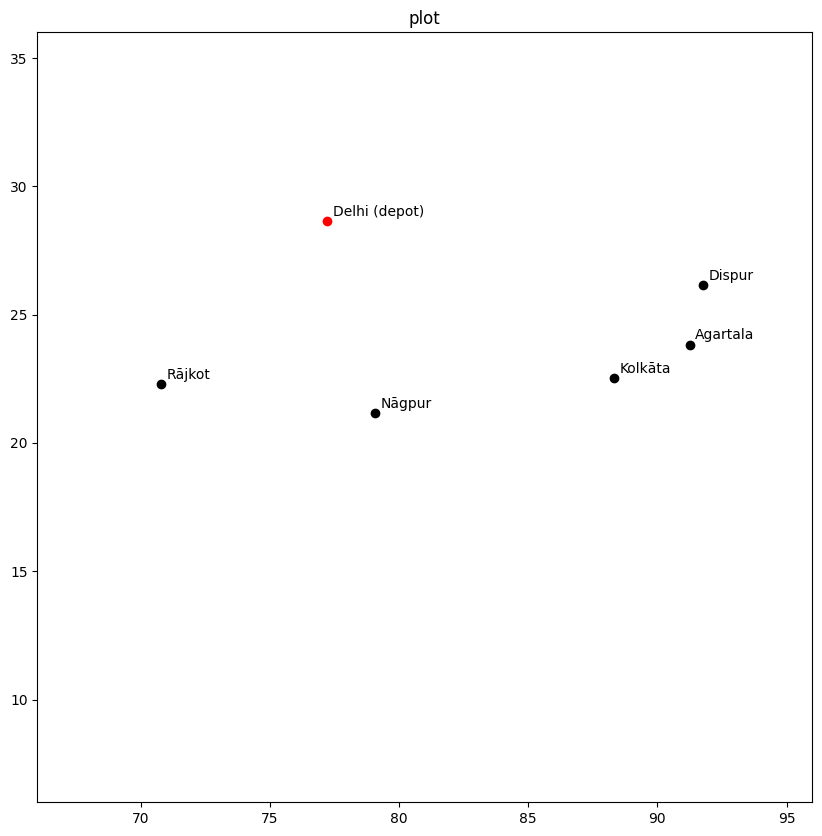

In [67]:
number_of_locs = 6
slice_df = df.copy().head(number_of_locs)
slice_distance = slice_df[["x", "y"]]

matrix = pd.DataFrame(
    distance_matrix(slice_distance.values, slice_distance.values),
    index=slice_distance.index,
    columns=slice_distance.index,
)

plot_cities_fig(slice_df)
plt.show()

## Model

In [68]:
model = pulp.LpProblem("tsp", pulp.LpMinimize)

x = pulp.LpVariable.dicts(
    "x",
    ((i, j) for i in range(number_of_locs) for j in range(number_of_locs)),
    cat="Binary",
)

model += pulp.lpSum(
    matrix[i][j] * x[i, j] for i in range(number_of_locs) for j in range(number_of_locs)
)

for i in range(number_of_locs):
    model += x[i, i] == 0
    model += pulp.lpSum(x[i, j] for j in range(number_of_locs)) == 1
    model += pulp.lpSum(x[j, i] for j in range(number_of_locs)) == 1

status = model.solve()

route = [
    (i, j)
    for i in range(number_of_locs)
    for j in range(number_of_locs)
    if pulp.value(x[i, j]) == 1
]

route

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/codeyan/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/ffb933b8bf6f4e10bb81de423d6ca013-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/ffb933b8bf6f4e10bb81de423d6ca013-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 23 COLUMNS
At line 204 RHS
At line 223 BOUNDS
At line 260 ENDATA
Problem MODEL has 18 rows, 36 columns and 78 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 35.6944 - 0.00 seconds
Cgl0002I 6 variables fixed
Cgl0004I processed model has 12 rows, 30 columns (30 integer (30 of which binary)) and 60 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 35.6944
Cbc0038I Before mini branch and bound, 30 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and bound did not improve s

[(0, 2), (1, 0), (2, 1), (3, 5), (4, 3), (5, 4)]

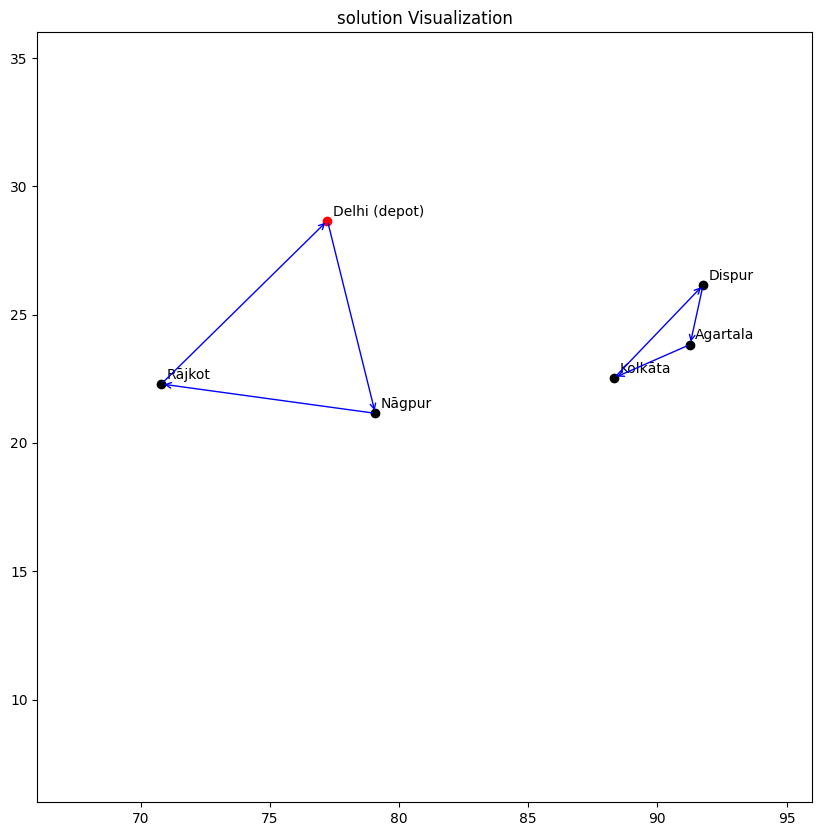

In [69]:
plot_cities_fig(slice_df, heading="solution Visualization")
arrowprops = dict(arrowstyle="->", connectionstyle="arc3", edgecolor="blue")
for i, j in route:
    plt.annotate(
        "",
        xy=[slice_df.iloc[j]["x"], slice_df.iloc[j]["y"]],
        xytext=[slice_df.iloc[i]["x"], slice_df.iloc[i]["y"]],
        arrowprops=arrowprops,
    )

## Fixing subtour with MTZ approach

In [70]:
model = pulp.LpProblem("tsp", pulp.LpMinimize)

x = pulp.LpVariable.dicts(
    "x",
    ((i, j) for i in range(number_of_locs) for j in range(number_of_locs)),
    cat="Binary",
)

t = pulp.LpVariable.dicts(
    "t",
    (i for i in range(number_of_locs)),
    lowBound=1,
    upBound=number_of_locs,
    cat="Continuous",
)

model += pulp.lpSum(
    matrix[i][j] * x[i, j] for i in range(number_of_locs) for j in range(number_of_locs)
)

for i in range(number_of_locs):
    model += x[i, i] == 0
    model += pulp.lpSum(x[i, j] for j in range(number_of_locs)) == 1
    model += pulp.lpSum(x[j, i] for j in range(number_of_locs)) == 1

for i in range(number_of_locs):
    for j in range(number_of_locs):
        if i != j and (i != 0 and j != 0):
            model += t[j] >= t[i] + 1 - (2 * number_of_locs) * (1 - x[i, j])


status = model.solve()

route = [
    (i, j)
    for i in range(number_of_locs)
    for j in range(number_of_locs)
    if pulp.value(x[i, j]) == 1
]

route

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/codeyan/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/bd7c5153f3474432bff108146952a07d-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/bd7c5153f3474432bff108146952a07d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 43 COLUMNS
At line 284 RHS
At line 323 BOUNDS
At line 370 ENDATA
Problem MODEL has 38 rows, 41 columns and 138 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 35.6944 - 0.00 seconds
Cgl0002I 6 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 20 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 20 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 20 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 20 strengthened rows, 0 substitutions
Cgl0004I process

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0)]

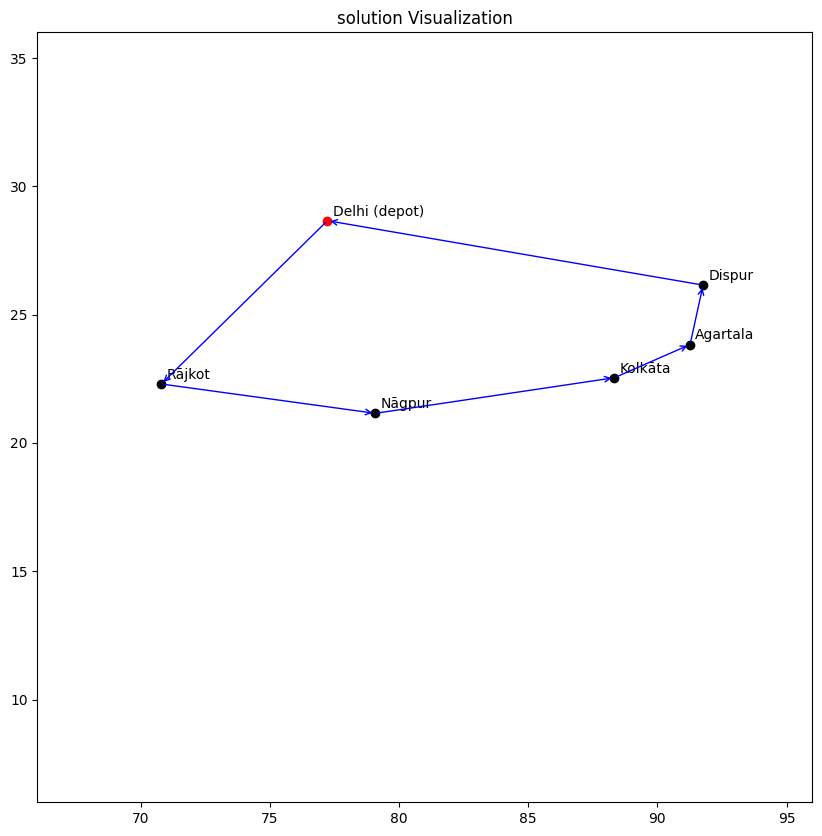

In [71]:
plot_cities_fig(slice_df, heading="solution Visualization")
arrowprops = dict(arrowstyle="->", connectionstyle="arc3", edgecolor="blue")
for i, j in route:
    plt.annotate(
        "",
        xy=[slice_df.iloc[j]["x"], slice_df.iloc[j]["y"]],
        xytext=[slice_df.iloc[i]["x"], slice_df.iloc[i]["y"]],
        arrowprops=arrowprops,
    )